In [1]:
import PIL
import jax.numpy as jnp
from tensorflow.io import gfile
from scenic.projects.boundary_attention.configs import base_config
from scenic.projects.boundary_attention.helpers import train_utils
from scenic.projects.boundary_attention.helpers import viz_utils

import tensorflow_datasets as tfds
import scenic.projects.boundary_attention.kaleidoshapes.kaleidoshapes

import ml_collections
import jax

from scenic.projects.boundary_attention.dataset_lib import dataloader
from scenic.projects.boundary_attention.configs import kaleidoshapes_config
from scenic.projects.boundary_attention.dataset_lib.datasets import kaleidoshapes_dataset

import matplotlib.pyplot as plt

import numpy as np



In [2]:
#from scenic.projects.boundary_attention.helpers import additive_noise_model

In [123]:
import numpy as np
import scipy.stats as stats
from os.path import join


class RawPacker:
    def __init__(self, cfa='bayer'):
        self.cfa = cfa

    def pack_raw_bayer(self, cfa_img):
        # pack Bayer image to 4 channels
        img_shape = cfa_img.shape
        H = img_shape[0]
        W = img_shape[1]

        out = np.stack((cfa_img[0:H:2, 0:W:2], # RGBG
                        cfa_img[0:H:2, 1:W:2],
                        cfa_img[1:H:2, 1:W:2],
                        cfa_img[1:H:2, 0:W:2]), axis=0).astype(np.float32)
        return out
    
    def pack_raw_xtrans(self, cfa_img):
        # pack X-Trans image to 9 channels
        img_shape = cfa_img.shape
        H = (img_shape[0] // 6) * 6
        W = (img_shape[1] // 6) * 6

        out = np.zeros((9, H // 3, W // 3), dtype=np.float32)

        # 0 R
        out[0, 0::2, 0::2] = cfa_img[0:H:6, 0:W:6]
        out[0, 0::2, 1::2] = cfa_img[0:H:6, 4:W:6]
        out[0, 1::2, 0::2] = cfa_img[3:H:6, 1:W:6]
        out[0, 1::2, 1::2] = cfa_img[3:H:6, 3:W:6]

        # 1 G
        out[1, 0::2, 0::2] = cfa_img[0:H:6, 2:W:6]
        out[1, 0::2, 1::2] = cfa_img[0:H:6, 5:W:6]
        out[1, 1::2, 0::2] = cfa_img[3:H:6, 2:W:6]
        out[1, 1::2, 1::2] = cfa_img[3:H:6, 5:W:6]

        # 1 B
        out[2, 0::2, 0::2] = cfa_img[0:H:6, 1:W:6]
        out[2, 0::2, 1::2] = cfa_img[0:H:6, 3:W:6]
        out[2, 1::2, 0::2] = cfa_img[3:H:6, 0:W:6]
        out[2, 1::2, 1::2] = cfa_img[3:H:6, 4:W:6]

        # 4 R
        out[3, 0::2, 0::2] = cfa_img[1:H:6, 2:W:6]
        out[3, 0::2, 1::2] = cfa_img[2:H:6, 5:W:6]
        out[3, 1::2, 0::2] = cfa_img[5:H:6, 2:W:6]
        out[3, 1::2, 1::2] = cfa_img[4:H:6, 5:W:6]

        # 5 B
        out[4, 0::2, 0::2] = cfa_img[2:H:6, 2:W:6]
        out[4, 0::2, 1::2] = cfa_img[1:H:6, 5:W:6]
        out[4, 1::2, 0::2] = cfa_img[4:H:6, 2:W:6]
        out[4, 1::2, 1::2] = cfa_img[5:H:6, 5:W:6]

        out[5, :, :] = cfa_img[1:H:3, 0:W:3]
        out[6, :, :] = cfa_img[1:H:3, 1:W:3]
        out[7, :, :] = cfa_img[2:H:3, 0:W:3]
        out[8, :, :] = cfa_img[2:H:3, 1:W:3]
        return out

    def unpack_raw_bayer(self, img):        
        # unpack 4 channels to Bayer image
        img4c = img
        _, h, w = img.shape

        H = int(h * 2)
        W = int(w * 2)

        cfa_img = np.zeros((H, W), dtype=np.float32)

        cfa_img[0:H:2, 0:W:2] = img4c[0, :,:]
        cfa_img[0:H:2, 1:W:2] = img4c[1, :,:]
        cfa_img[1:H:2, 1:W:2] = img4c[2, :,:]
        cfa_img[1:H:2, 0:W:2] = img4c[3, :,:]
        
        return cfa_img

    def unpack_raw_xtrans(self, img):        
        img9c = img
        _, h, w = img.shape
        
        H = int(h * 3)
        W = int(w * 3)

        cfa_img = np.zeros((H, W), dtype=np.float32)

        # 0 R
        cfa_img[0:H:6, 0:W:6] = img9c[0, 0::2, 0::2]
        cfa_img[0:H:6, 4:W:6] = img9c[0, 0::2, 1::2]
        cfa_img[3:H:6, 1:W:6] = img9c[0, 1::2, 0::2]
        cfa_img[3:H:6, 3:W:6] = img9c[0, 1::2, 1::2]

        # 1 G
        cfa_img[0:H:6, 2:W:6] = img9c[1, 0::2, 0::2]
        cfa_img[0:H:6, 5:W:6] = img9c[1, 0::2, 1::2]
        cfa_img[3:H:6, 2:W:6] = img9c[1, 1::2, 0::2]
        cfa_img[3:H:6, 5:W:6] = img9c[1, 1::2, 1::2]

        # 1 B
        cfa_img[0:H:6, 1:W:6] = img9c[2, 0::2, 0::2]
        cfa_img[0:H:6, 3:W:6] = img9c[2, 0::2, 1::2]
        cfa_img[3:H:6, 0:W:6] = img9c[2, 1::2, 0::2]
        cfa_img[3:H:6, 4:W:6] = img9c[2, 1::2, 1::2]

        # 4 R
        cfa_img[1:H:6, 2:W:6] = img9c[3, 0::2, 0::2]
        cfa_img[2:H:6, 5:W:6] = img9c[3, 0::2, 1::2] 
        cfa_img[5:H:6, 2:W:6] = img9c[3, 1::2, 0::2] 
        cfa_img[4:H:6, 5:W:6] = img9c[3, 1::2, 1::2] 

        # 5 B
        cfa_img[2:H:6, 2:W:6] = img9c[4, 0::2, 0::2]
        cfa_img[1:H:6, 5:W:6] = img9c[4, 0::2, 1::2]
        cfa_img[4:H:6, 2:W:6] = img9c[4, 1::2, 0::2]
        cfa_img[5:H:6, 5:W:6] = img9c[4, 1::2, 1::2]

        cfa_img[1:H:3, 0:W:3] = img9c[5, :, :]
        cfa_img[1:H:3, 1:W:3] = img9c[6, :, :]
        cfa_img[2:H:3, 0:W:3] = img9c[7, :, :]
        cfa_img[2:H:3, 1:W:3] = img9c[8, :, :]
        
        return cfa_img    
    
    def pack_raw(self, cfa_img):
        if self.cfa == 'bayer':
            out = self.pack_raw_bayer(cfa_img)
        elif self.cfa == 'xtrans':
            out = self.pack_raw_xtrans(cfa_img)
        else:
            raise NotImplementedError
        return out

    def unpack_raw(self, img):
        if self.cfa == 'bayer':
            out = self.unpack_raw_bayer(img)
        elif self.cfa == 'xtrans':
            out = self.unpack_raw_xtrans(img)
        else:
            raise NotImplementedError        
        return out


class NoiseModelBase:  # base class
    def __call__(self, y, params=None):
        if params is None:
            K, g_scale, saturation_level, ratio = self._sample_params()
        else:
            K, g_scale, saturation_level, ratio = params

        y = y * saturation_level
        y = y / ratio
        
        if 'P' in self.model:
            z = np.random.poisson(y / K).astype(np.float32) * K
        elif 'p' in self.model:
            z = y + np.random.randn(*y.shape).astype(np.float32) * np.sqrt(np.maximum(K * y, 1e-10))
        else:
            z = y

        if 'g' in self.model:
            z = z + np.random.randn(*y.shape).astype(np.float32) * np.maximum(g_scale, 1e-10)  # Gaussian noise

        z = z * ratio
        z = z / saturation_level
        return z


# Only support baseline noise models: G / G+P / G+P* 
class NoiseModel(NoiseModelBase):
    def __init__(self, model='g', cameras=None, include=None, exclude=None, cfa='bayer'):
        super().__init__()
        assert cfa in ['bayer', 'xtrans']
        assert include is None or exclude is None
        self.cameras = cameras or ['CanonEOS5D4', 'CanonEOS70D', 'CanonEOS700D', 'NikonD850', 'SonyA7S2']        

        if include is not None:
            self.cameras = [self.cameras[include]]
        if exclude is not None:
            exclude_camera = set([self.cameras[exclude]])
            self.cameras = list(set(self.cameras) - exclude_camera)

        self.param_dir = 'camera_params'#join('camera_params', 'release')

        print('[i] NoiseModel with {}'.format(self.param_dir))
        print('[i] cameras: {}'.format(self.cameras))
        print('[i] using noise model {}'.format(model))
        
        self.camera_params = {}

        for camera in self.cameras:
            self.camera_params[camera] = np.load(join(self.param_dir, camera+'_params.npy'), allow_pickle=True).item()

        self.model = model
        self.raw_packer = RawPacker(cfa)

    def _sample_params(self):
        camera = np.random.choice(self.cameras)
        # print(camera)

        saturation_level = 16383 - 800
        profiles = ['Profile-1']

        camera_params = self.camera_params[camera]
        Kmin = camera_params['Kmin']
        Kmax = camera_params['Kmax']
        profile = np.random.choice(profiles)
        camera_params = camera_params[profile]

        log_K = np.random.uniform(low=np.log(Kmin), high=np.log(Kmax))
        #log_K = np.random.uniform(low=np.log(1e-1), high=np.log(30))
        
        log_g_scale = np.random.standard_normal() * camera_params['g_scale']['sigma'] * 1 +\
             camera_params['g_scale']['slope'] * log_K + camera_params['g_scale']['bias']

        K = np.exp(log_K)
        g_scale = np.exp(log_g_scale)

        ratio = np.random.uniform(low=100, high=300)

        return (K, g_scale, saturation_level, ratio)


In [125]:
weights_dir = 'scenic/projects/boundary_attention/pretrained_weights/' # Add path to pretrained weights here

im_height = 216 # Replace with height to resize input to
im_width = 216  # Replace with width to resize input to

config = base_config.get_config(model_name='boundary_attention',
                                  dataset_name='testing',
                                  input_size=(im_height, im_width, 3))

apply_jitted, trained_params = train_utils.make_apply(config, weights_dir)

In [182]:
nm = NoiseModel(model = "G+P*")

img_path = 'IMG_0002.png' # Replace with path to new input

############################################

input_img = jnp.array(PIL.Image.open(gfile.GFile(img_path, 'rb')).resize((im_width, im_height)))/255.0

#input_img = np.clip(input_img + np.random.normal(0, 0.6, input_img.shape),0,1)
noisy_img = jnp.clip(jnp.array(nm(input_img)),0,1)
#noisy_img = jnp.clip(input_img + np.random.normal(0, 0.4, input_img.shape) ,0,1)

[i] NoiseModel with camera_params
[i] cameras: ['CanonEOS5D4', 'CanonEOS70D', 'CanonEOS700D', 'NikonD850', 'SonyA7S2']
[i] using noise model G+P*


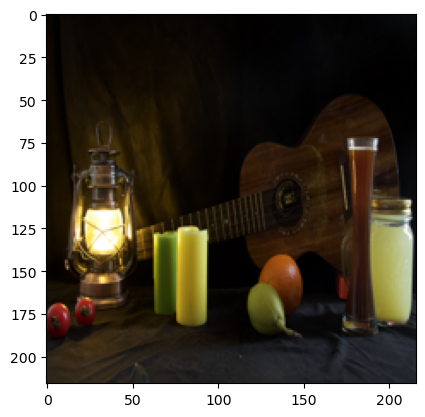

In [184]:
plt.imshow(input_img)

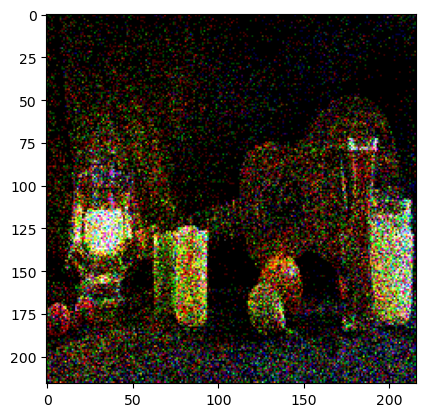

In [185]:
plt.imshow(noisy_img)

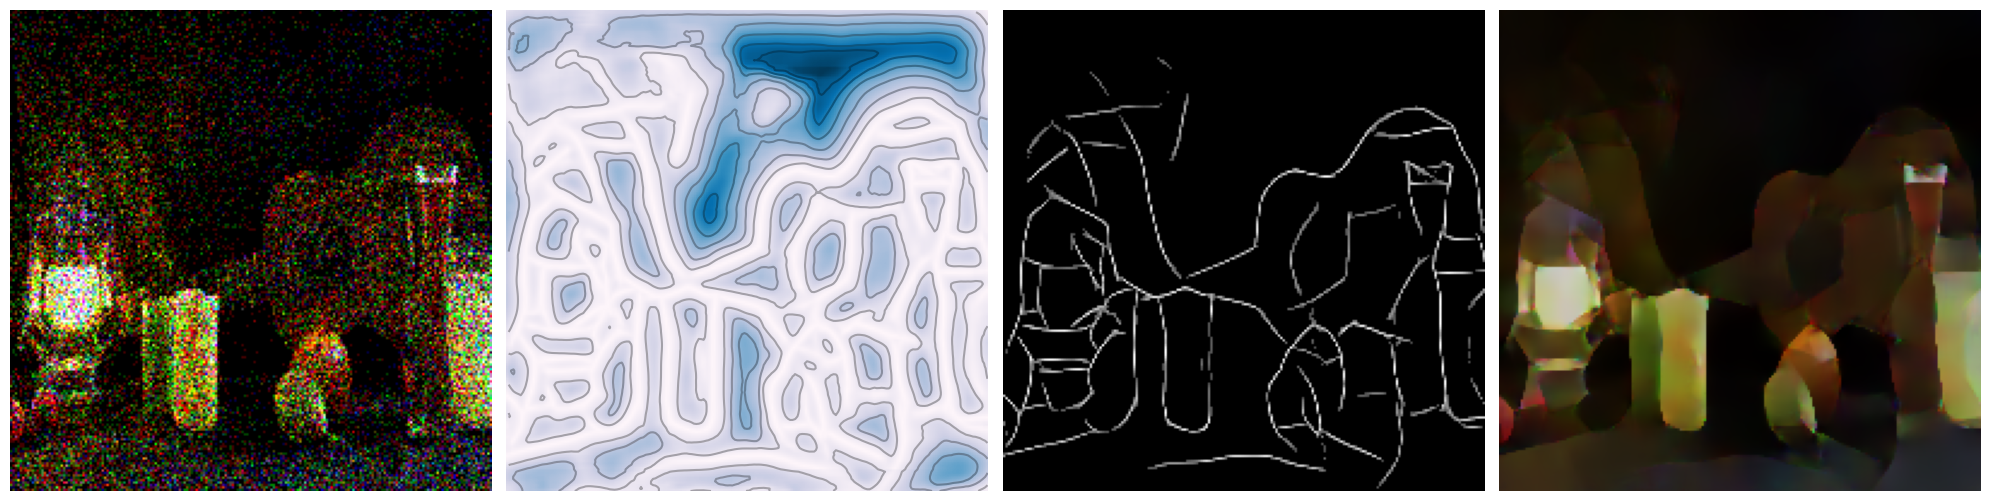

In [188]:
input_img = jnp.expand_dims(noisy_img.transpose(2,0,1)[:3,:,:], axis=0)

outputs = apply_jitted(trained_params['params'], input_img)
viz_utils.visualize_outputs(input_img, outputs)

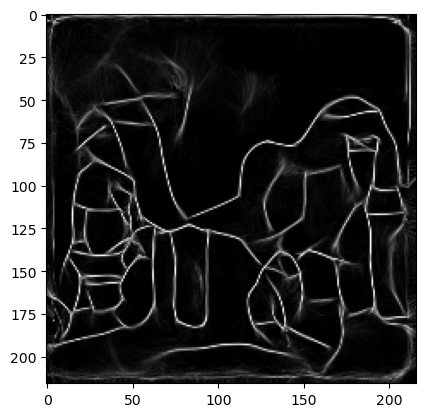

In [189]:
boundaries = outputs[-1]['global_boundaries'].squeeze()

plt.imshow(boundaries, cmap = "grey")

In [38]:

kaleidoshapes_dir = 'scenic/projects/boundary_attention/kaleidoshapes_dataset/kaleidoshapes' # Add path to kaleidoshapes here
kaleidoshapes_dataset = tfds.load('kaleidoshapes', data_dir=kaleidoshapes_dir, download=False)

In [52]:

batch_size = 5
rng_seed = 0

config = ml_collections.ConfigDict()
config.dataset = kaleidoshapes_config.get_config_kaleidoshapes(kaleidoshapes_dir)
# You can adjust the dataset here, as an example:
config.dataset.crop_size = (125, 125, 3)
config.batch_size = batch_size
config.eval_batch_size = batch_size

kaleidoshapes_dataset = dataloader.get_dataloader(config, jax.random.PRNGKey(rng_seed))

example_batch = next(kaleidoshapes_dataset.train_iter)

dict_keys(['basecolor', 'boundaries', 'clean_image', 'crop_start', 'distances', 'image', 'image_index', 'intersections', 'iv_mask', 'num_intersections', 'num_shapes', 'num_vertices', 'segments', 'shapes', 'vertices'])


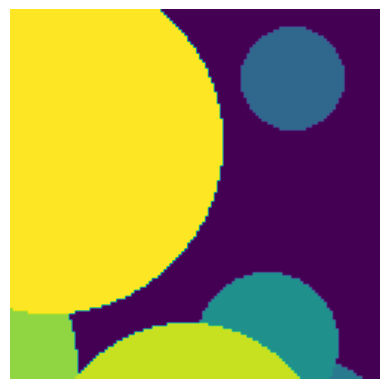

In [53]:
print(example_batch.keys())

plt.imshow(example_batch['segments'][0, 2, :, :, :].reshape(125,125,1))
plt.axis('off')
plt.savefig('test.png')

In [285]:
weights_dir = 'scenic/projects/boundary_attention/pretrained_weights/' # Add path to pretrained weights here

im_height = 125 # Replace with height to resize input to
im_width = 125 # Replace with width to resize input to

config = base_config.get_config(model_name='boundary_attention',
                                  dataset_name='testing',
                                  input_size=(im_height, im_width, 3))

apply_jitted, trained_params = train_utils.make_apply(config, weights_dir)

In [297]:
print(type(example_batch['segments'][0, 2, :, :, :].reshape(125,125,1)))

<class 'jaxlib.xla_extension.ArrayImpl'>


In [529]:
######## MODIFY THE OPTIONS BELOW #########

#img_path = 'test.png' # Replace with path to new input

img = np.moveaxis(np.array(example_batch['segments'][0, 2, :, :, :]), 0, 2)
temp = PIL.Image.fromarray(img.astype(np.uint8)[:,:,0], mode='L').convert("RGB")
input_img_2 = jnp.array(temp)/255
input_img_2 = jnp.expand_dims(input_img_2.transpose(2,0,1)[:3,:,:], axis=0)


#outputs = apply_jitted(trained_params['params'], input_img)

#print(outputs)

#viz_utils.visualize_outputs(input_img, outputs)

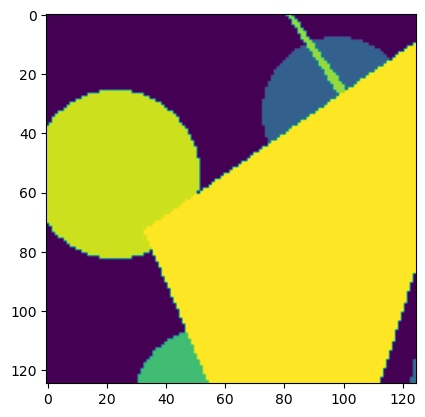

In [549]:
plt.imshow(img)

In [197]:
def create_dataloader(batch_size, 
                      dataset_dir = 'scenic/projects/boundary_attention/kaleidoshapes_dataset/kaleidoshapes',
                      rng_seed = 0, 
                      imshape = (125,125,3)
                     ):
    #intialize config
    config = ml_collections.ConfigDict()
    
    #config settings
    config.dataset = kaleidoshapes_config.get_config_kaleidoshapes(dataset_dir)
    config.dataset.crop_size = imshape
    config.batch_size = batch_size
    config.eval_batch_size = batch_size
    
    #create_dataloader
    kaleidoshapes_dataset = dataloader.get_dataloader(config, jax.random.PRNGKey(rng_seed))

    return(kaleidoshapes_dataset)


In [235]:
def create_model_BA(weights_dir = 'scenic/projects/boundary_attention/pretrained_weights/', 
                    imshape = (125,125,3)):
    config = base_config.get_config(model_name='boundary_attention',
                                  dataset_name='testing',
                                  input_size=imshape)
    return train_utils.make_apply(config, weights_dir) # tuple: (apply_jitted, trained_params)

In [247]:
def apply_noise(img, sigma):
    return(img)

In [551]:
def create_batch(data_loader,
                 boundary_model, # tuple: (apply_jitted, trained_params)
                 noise_levels = [0.1], 
                 num_images_per_level = 1
                ):
    
    next_batch = next(data_loader.train_iter)

    processed_batch = {}

    for i in range(next_batch['segments'].shape[1]):
        img_out = []
        for noise in noise_levels:
            for j in range(num_images_per_level):
                img_arr = np.moveaxis(np.array(next_batch['segments'][0, i, :, :, :]), 0, 2)

                noisy_img = apply_noise(img_arr, noise)
                
                img = PIL.Image.fromarray(noisy_img.astype(np.uint8)[:,:,0], mode='L').convert("RGB")
                img = jnp.array(img)/255
                
                input_img = jnp.expand_dims(img.transpose(2,0,1)[:3,:,:], axis=0)
    
                outputs = boundary_model[0](boundary_model[1]['params'], input_img)

                boundaries = (outputs[-1]['global_boundaries'].squeeze() * 
                              (outputs[-1]['global_boundaries'].squeeze() > .3))[8:-8, 8:-8]

                img_out.append((img_arr, noise, noisy_img, boundaries))

            
        processed_batch[i] = img_out

    return processed_batch

In [553]:
batch = create_batch(create_dataloader(5), create_model_BA())

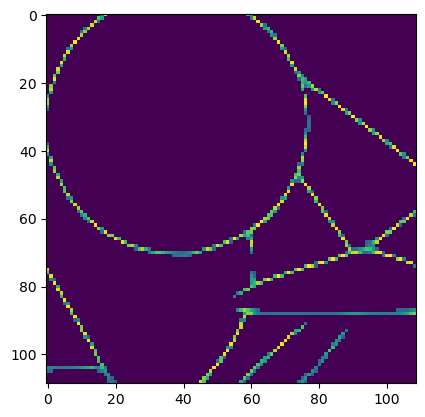

In [559]:
plt.imshow(batch[0][0][3])